### Rubén Barco Terrones

#### Create an artificial data set the breaks the assumtions of Mixture of Gaussians as computed in class. Report and comment this. Highlight how one could handle the proposed datas set.

I have created an square and I have rotate it to make a diamond. Each side of the diamond corresponds to one different set, so K=4 in this example. We can see that the Mixture of Gaussians doesn't work well with this dataset.

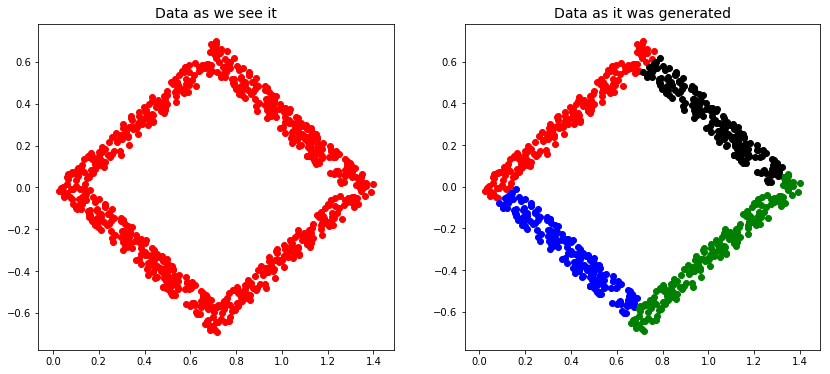

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

n_points = 200

xmin1 = 0
xmax1 = 0.1
ymin1 = 0
ymax1 = 1
x1 = []
y1 = []
for i in range(n_points):
    while True:
        x,y = random.uniform(0,1), random.uniform(0,1)
        if (x<xmax1 and x>=xmin1) and (y<=ymax1 and y>=ymin1):
            break
    x1.append(x)
    y1.append(y)

x1 = np.asarray(x1)
y1 = np.asarray(y1)
    
xmin2 = 0.11
xmax2 = 0.89
ymin2 = 0
ymax2 = 0.11
x2 = []
y2 = []
for i in range(n_points):
    while True:
        x,y = random.uniform(0,1), random.uniform(0,1)
        if (x<xmax2 and x>=xmin2) and (y<=ymax2 and y>=ymin2):
            break
    x2.append(x)
    y2.append(y)

x2 = np.asarray(x2)
y2 = np.asarray(y2)
    
x3 = x1+0.9
y3 = y1

x4 = x2
y4 = y2+0.89

X1 = np.array([x1,y1]).T
X2 = np.array([x2,y2]).T
X3 = np.array([x3,y3]).T
X4 = np.array([x4,y4]).T

X = np.concatenate([X1,X2,X3,X4])
y = np.concatenate([np.ones((n_points,1))])
y = np.concatenate([y,2*np.ones((n_points,1))])
y = np.concatenate([y,3*np.ones((n_points,1))])
y = np.concatenate([y,4*np.ones((n_points,1))])

angle = 45*math.pi/180
rot = np.array([[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]])
X = np.matmul(X,rot)

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.title('Data as we see it', size=14)

plt.subplot(1,2,2)
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='g')
plt.scatter(X[(y==4).ravel(),0],X[(y==4).ravel(),1],color='k')
plt.title('Data as it was generated',size=14)
fig=plt.gcf()
fig.set_size_inches((14,6))


[[ 0.99262182 -0.05485232]
 [ 0.85012621 -0.76134086]
 [-0.8932003   0.9011067 ]
 [ 0.25557288  0.27514449]]


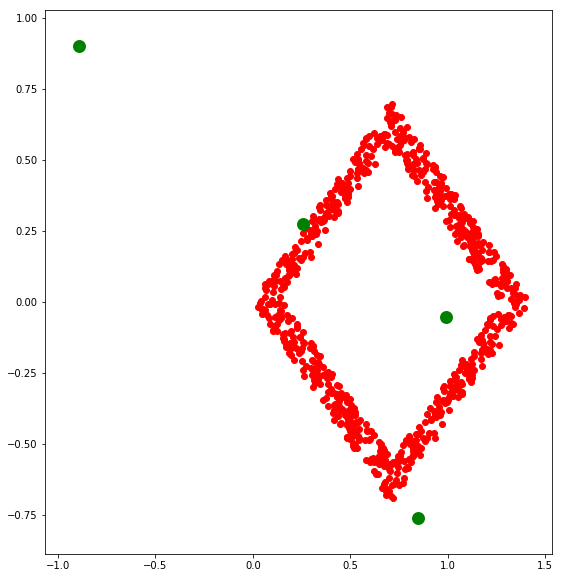

In [49]:
K = 4
idx=np.random.randint(0,X.shape[0],K)
C=2*np.random.rand(K,X.shape[1])-1
Sigma=100.*np.ones((K,X.shape[1]))
Pi=(1./K)*np.ones((K,1))
print (C)
plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='green', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((20,10))

[[0.00485641 0.01883676]
 [0.01638705 0.00475957]
 [0.00481264 0.01599122]
 [0.01778165 0.00455738]] [[0.26829915]
 [0.25921497]
 [0.2316343 ]
 [0.24085158]]


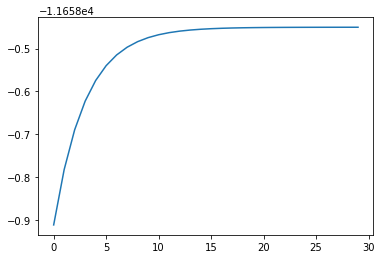

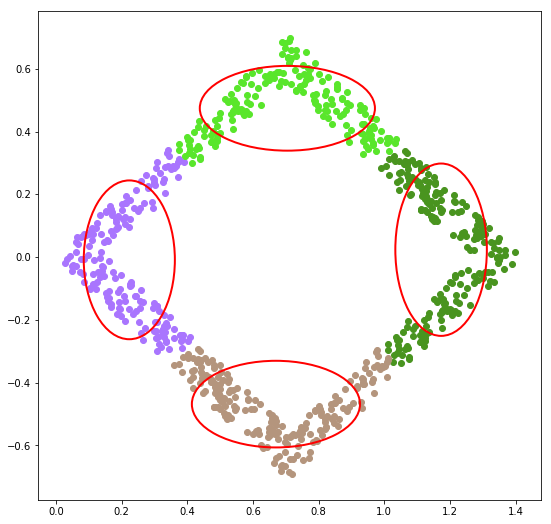

In [51]:
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist

def define_responsibilities(X,C,Sigma,Pi):
    r = np.zeros((X.shape[0],C.shape[0]))
    for i in range(C.shape[0]):
        d = cdist(C[i,:][np.newaxis,:],X,metric='seuclidean',V=Sigma[i,:])**2
        r[:,i]=Pi[i]*np.exp(-0.5*d)/np.prod(np.sqrt(2*np.pi)*Sigma[i,:])
    r = r/np.tile(np.sum(r,axis=1)[:,np.newaxis],(1,C.shape[0]))
    return r

def soft_kmeans2_iter(X,C,Sigma,Pi):
    I=X.shape[1]
    r = define_responsibilities(X,C,Sigma,Pi)
    for k in range(C.shape[0]):
        C[k,:]=np.sum((np.tile(r[:,k][:,np.newaxis],(1,C.shape[1]))*X),axis=0)/np.sum(r[:,k])
        Sigma[k,:]= np.sum(np.tile(r[:,k][:,np.newaxis],(1,C.shape[1]))*(X-np.tile(C[k,:][np.newaxis,:],(X.shape[0],1)))**2,axis=0)/(I*np.sum(r[:,k]))
        Pi[k]=np.sum(r[:,k])/np.sum(r) 
    return C,Sigma,Pi

def evaluate_objective(X,C,Sigma,Pi):
    J=0
    for k in range(C.shape[1]):
        J += Pi[k]*multivariate_normal.pdf(X, mean=C[k,:], cov=Sigma[k,:])
    return np.sum(np.log(J))
    
conv=[]
for iter in range(30):
    conv.append(evaluate_objective(X,C,Sigma,Pi))
    C,Sigma,Pi = soft_kmeans2_iter(X,C,Sigma,Pi)
print (Sigma,Pi)

plt.figure()
plt.plot(conv)
plt.figure()
r = define_responsibilities(X,C,Sigma,Pi)
y_pred = np.argmax(r,axis=1)
for label in np.unique(y_pred):
    plt.scatter(X[(y_pred==label).ravel(),0],X[(y_pred==label).ravel(),1],color=[np.random.rand(),np.random.rand(),np.random.rand()])

    
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='none', 
           linewidths=2,
           zorder=10)

from matplotlib.patches import Ellipse
ax = plt.gca()
ellipse = Ellipse(xy=C[0,:], width=4*np.sqrt(Sigma[0,0]), height=4*np.sqrt(Sigma[0,1]), 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)

ellipse = Ellipse(xy=C[1,:], width=4*np.sqrt(Sigma[1,0]), height=4*np.sqrt(Sigma[1,1]), 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)

ellipse = Ellipse(xy=C[2,:], width=4*np.sqrt(Sigma[2,0]), height=4*np.sqrt(Sigma[2,1]), 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)

ellipse = Ellipse(xy=C[3,:], width=4*np.sqrt(Sigma[3,0]), height=4*np.sqrt(Sigma[3,1]), 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)


fig = plt.gcf()
fig.set_size_inches((9,9))